# Определение возраста покупателей

# Введение

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.

Цель проекта: Построить модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

Задачи:
- провести исследоватьльский анализ данных
- обучить модель.



## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50



In [2]:
data = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1/255.)
datagen_flow = datagen.flow_from_dataframe(dataframe=data,
                                                    directory = '/datasets/faces/final_files/',
                                                    x_col = 'file_name',
                                                    y_col = 'real_age',
                                                    target_size = (224,224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    seed=12345)

Found 7591 validated image filenames.


In [3]:
data.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


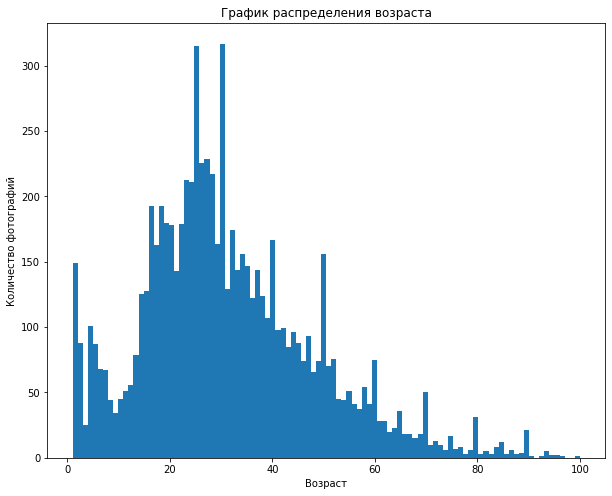

In [4]:
fig = plt.figure(figsize=(10,8))
plt.hist(data['real_age'], bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество фотографий')
plt.title('График распределения возраста')

plt.show()

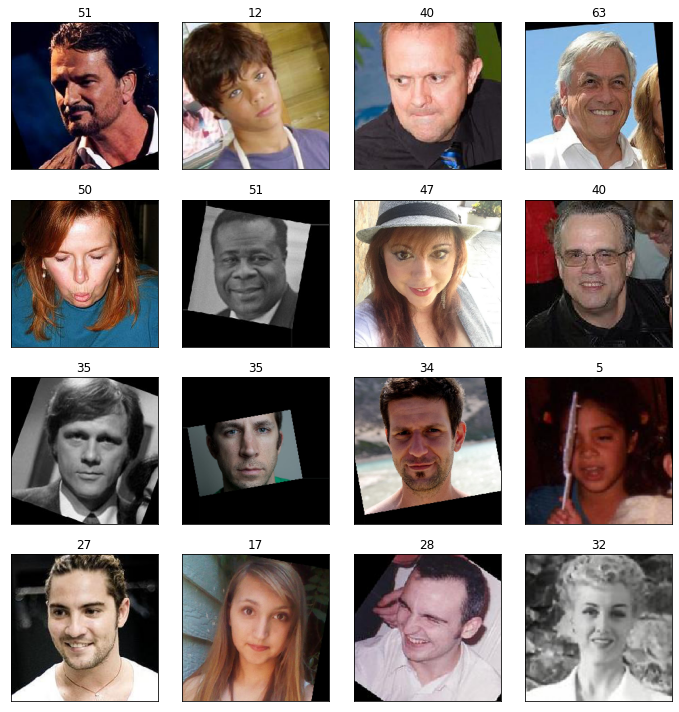

In [7]:
features, target = next(datagen_flow)
fi = plt.figure(figsize=(10,10))
for i in range(16):
    fi.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title(target[i])

# Вывод
Всего 7591 фотография. Большинство фотографий находится в диапозоне от 20 до 41 года. Миниальный возраст 1 год, таких фотографий около 150. Максимальный возраст 100 лет. На значениях, кратных 10 заметно повышкнное количество изображений. Данные аномалии нужны для того, чтобы модель выбирала промежуток предсказания. Изменения во внешности каждые 10 лет достаточно сильно проявляются, однако эти аномалии могут сказаться на точных предсказаниях. В общем модели будет проще угадать диапозог возраста покупателя, кратный 10ти.


## Обучение модели

Код ниже запускался на GPU серивре Яндекса, поэтому оформлен в ячейке Markdown.

```python
def load_train(path):

    data = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=data,
                                                       directory=(path + 'final_files/'),
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='training',
                                                       seed=12345)
    return train_gen_flow

def load_test(path):

    datas = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1 / 255.)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=datas,
                                                       directory=(path + 'final_files/'),
                                                       x_col='file_name',
                                                       y_col='real_age',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='raw',
                                                       subset='validation',
                                                       seed=12345)
    return test_gen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='imagenet',
                        include_top=False)              
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=256, activation='relu')) 
    model.add(Dense(units=128, activation='relu'))
    model.add(Dense(units=1, activation='relu'))
    opt = Adam(lr=0.0005)  
    model.compile(loss='mean_squared_error',
                  optimizer=opt, metrics=['mae'])                   
    return model

def train_model(model, train_data, data_test, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        validation_steps = len(data_test)
    model.fit(train_data, validation_data=data_test,
              batch_size=batch_size, epochs=epochs, steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps, verbose=2, shuffle=True)
    return model
```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 46s - loss: 200.1882 - mae: 10.6762 - val_loss: 298.5883 - val_mae: 12.8739
Epoch 2/10
178/178 - 38s - loss: 113.5318 - mae: 8.1286 - val_loss: 285.6389 - val_mae: 12.8331
Epoch 3/10
178/178 - 37s - loss: 72.6666 - mae: 6.4934 - val_loss: 395.6502 - val_mae: 14.8495
Epoch 4/10
178/178 - 37s - loss: 45.5937 - mae: 5.2205 - val_loss: 250.3682 - val_mae: 11.5694
Epoch 5/10
178/178 - 37s - loss: 29.3654 - mae: 4.1770 - val_loss: 122.9903 - val_mae: 8.5306
Epoch 6/10
178/178 - 37s - loss: 22.8322 - mae: 3.6621 - val_loss: 79.6881 - val_mae: 6.8184
Epoch 7/10
178/178 - 38s - loss: 16.4643 - mae: 3.1178 - val_loss: 102.9156 - val_mae: 7.5413
Epoch 8/10
178/178 - 37s - loss: 13.4658 - mae: 2.7953 - val_loss: 78.3466 - val_mae: 6.8752
Epoch 9/10
178/178 - 37s - loss: 11.4184 - mae: 2.5810 - val_loss: 84.5343 - val_mae: 6.8163
Epoch 10/10
178/178 - 38s - loss: 10.2058 - mae: 2.4143 - val_loss: 82.1859 - val_mae: 7.0133

```

## Анализ обученной модели

Модель обучается быстро, менее 10ти минут. Этого времени ей хватает, чтобы достичь MAE 6.82. 5694 изображения послужили в качестве тренеровочных данных. Модель протестирована на 1897 фотографиях и в среднем ошибается на 7 лет. Далеко не каждый человек сможет достичь такого результа при угадывании возраста человка. 


load_train(path):

Функция загружает тренировочные данные из файлового пути path. Она использует ImageDataGenerator для предобработки данных, включая масштабирование пикселей изображений и разделение данных на тренировочный набор и валидационный набор в соотношении 3:1. Возвращает объект генератора train_gen_flow, который будет использоваться для обучения модели.

load_test(path): 

Функция загружает тестовые данные из файла в пути path. Она также использует ImageDataGenerator для предобработки данных и разделения на тренировочный и валидационный наборы в том же соотношении, что и в функции load_train. Возвращает объект генератора test_gen_flow, который будет использоваться для оценки модели.

create_model(input_shape):

Функция создает модель нейронной сети с архитектурой ResNet50. Архитектура ResNet50 является предварительно обученной на наборе данных ImageNet и используется здесь в качестве базовой модели. Добавляются несколько слоев, включая слой глобального среднего объединения, плотные слои с функцией активации ReLU и слой вывода с функцией активации ReLU, возвращающий непрерывное значение предсказанного возраста. Модель компилируется с использованием оптимизатора Adam и функции потерь mean_squared_error.

train_model(model, train_data, data_test, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):

Функция обучает модель на тренировочных данных (train_data) и оценивает ее на валидационных данных (data_test). Она принимает несколько параметров, включая размер пакета (batch_size), количество эпох (epochs), количество шагов на эпоху (steps_per_epoch) и количество шагов валидации (validation_steps). Если эти параметры не указаны, то функция автоматически определит их значения. Модель обучается с использованием функции fit, и возвращается обученная модель.

С учетом полученных результатов можно рекомендовать использовать данную модель для выполнения первой поставленной задачи — анализировать покупки и предлагать товары, которые могут заинтересовать покупателей определенной возрастной группы при предварительной категоризации потенциальных покупателей.
    
Что касается второй задачи — контролировать добросовестность кассиров при продаже алкоголя — с учетом полученного MAE, модель не покажет хороших результатов на практике.

# Вывод:
- Исследовательский анализ данных выполнен
- Модель корректна, порог в MAE 8 преодолен
